In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

In [25]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

# Appendix A: Model dynamics

## A1 Short-baseline model

In [3]:
NRUNS = 15

In [4]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [5]:
burn_in_period = 250

In [6]:
params

{'ticks': 850,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

In [7]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14


In [8]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=200)

Establish confidence interval for average prices

In [26]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_prices)):
    price_range = mc_prices.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

Identify sentiment 

In [31]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [43]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)

Identify individual agent wealth changes

In [57]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [77]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

Import all bubbles, and identify wins and losses 

In [ ]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

In [ ]:
runs = len(bubble_data)

bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = [] 
horizons = [] 
learning_abilities = [] 
chartist_expectations = [] 
fundamentalist_expectations = []

for r in range(runs):
    if bubble_data[r][1]:
        bubble_types += bubble_data[r][0]
        bubble_prices += bubble_data[r][1]
        wealth_starts += bubble_data[r][2]
        wealth_ends += bubble_data[r][3]
        ginis_ot += bubble_data[r][4]
        palmas_ot += bubble_data[r][5]
        twtws_ot += bubble_data[r][6]
        risk_aversions += bubble_data[r][7]
        horizons += bubble_data[r][8]
        learning_abilities += bubble_data[r][9]
        chartist_expectations += bubble_data[r][10]
        fundamentalist_expectations += bubble_data[r][11]
        
unique_bubble_types = list(set(bubble_types))

Calculate the inequality stats Gini, Palma, and Twenty-twenty

In [91]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(low)
    up_twtw_ot.append(up)

### Plot short-baseline:

1. price + fundamental, 
2. sentiment,
3. Distribution of profit 
4. gini,
5. palma, 
6. twenty twenty 

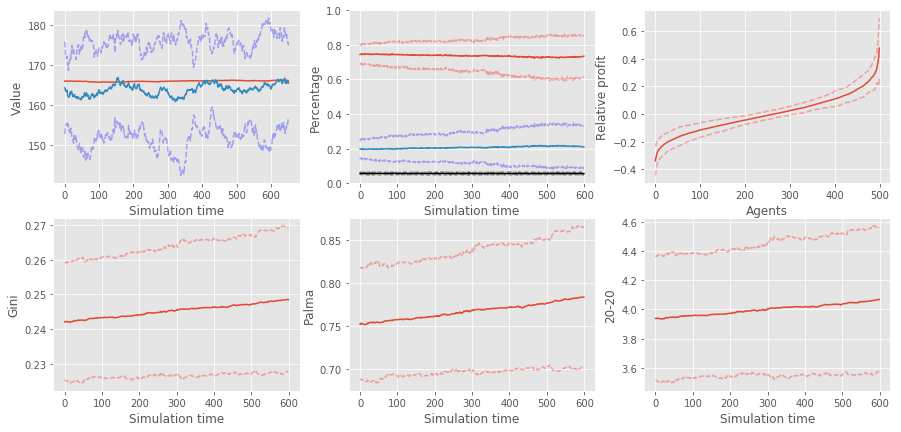

In [105]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), label='Market')
ax1.plot(mc_prices.index, lower_c_price, 'b--', alpha=0.3)
ax1.plot(mc_prices.index, upper_c_price, 'b--', alpha=0.3)

ax1.set_ylabel('Value', fontsize='12')
#ax1.legend(loc='best', fontsize='14')

ax2.plot(range(len(av_fundamentalist_sentiment[burn_in_period:])), av_fundamentalist_sentiment[burn_in_period:], label='fundamentalist ')
ax2.plot(range(len(lo_fundamentalist_sentiment[burn_in_period:])), lo_fundamentalist_sentiment[burn_in_period:], 'r--', alpha=0.3)
ax2.plot(range(len(up_fundamentalist_sentiment[burn_in_period:])), up_fundamentalist_sentiment[burn_in_period:], 'r--', alpha=0.3)
ax2.set_ylabel('Percentage', fontsize='12')

ax2.plot(range(len(av_trend_sentiment[burn_in_period:])), av_trend_sentiment[burn_in_period:], label='chartist ')
ax2.plot(range(len(lo_trend_sentiment[burn_in_period:])), lo_trend_sentiment[burn_in_period:], 'b--', alpha=0.3)
ax2.plot(range(len(up_trend_sentiment[burn_in_period:])), up_trend_sentiment[burn_in_period:], 'b--', alpha=0.3)

ax2.plot(range(len(av_random_sentiment[burn_in_period:])), av_random_sentiment[burn_in_period:], 'k', label='random ')
ax2.plot(range(len(lo_trend_sentiment[burn_in_period:])), lo_random_sentiment[burn_in_period:], 'k--', alpha=0.3)
ax2.plot(range(len(up_trend_sentiment[burn_in_period:])), up_random_sentiment[burn_in_period:], 'k--', alpha=0.3)
ax2.set_ylim(0, 1)

ax3.plot(range(len(av_ordered_profits)), av_ordered_profits)
ax3.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'r--', alpha=0.3)
ax3.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'r--', alpha=0.3)
ax3.set_ylabel('Relative profit', fontsize='12')

ax4.plot(range(len(av_gini_ot[burn_in_period:])), av_gini_ot[burn_in_period:])
ax4.plot(range(len(low_gini_ot[burn_in_period:])), low_gini_ot[burn_in_period:], 'r--', alpha=0.3)
ax4.plot(range(len(up_gini_ot[burn_in_period:])), up_gini_ot[burn_in_period:], 'r--', alpha=0.3)
ax4.set_ylabel('Gini', fontsize='12')

ax5.plot(range(len(av_gini_ot[burn_in_period:])), av_palma_ot[burn_in_period:])
ax5.plot(range(len(low_gini_ot[burn_in_period:])), low_palma_ot[burn_in_period:], 'r--', alpha=0.3)
ax5.plot(range(len(up_gini_ot[burn_in_period:])), up_palma_ot[burn_in_period:], 'r--', alpha=0.3)
ax5.set_ylabel('Palma', fontsize='12')

ax6.plot(range(len(av_gini_ot[burn_in_period:])), av_twtw_ot[burn_in_period:])
ax6.plot(range(len(low_gini_ot[burn_in_period:])), low_twtw_ot[burn_in_period:], 'r--', alpha=0.3)
ax6.plot(range(len(up_gini_ot[burn_in_period:])), up_twtw_ot[burn_in_period:], 'r--', alpha=0.3)
ax6.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='12')
    
ax3.set_xlabel('Agents', fontsize='12')

fig.savefig('short_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## A2 Long-baseline model

Find median price series